# Crime Prediction Through Machine Learning

**Author: Frank Serafine**  
[GitHub](https://github.com/fserafine) | [LinkedIn](https://www.linkedin.com/in/frankserafine/)

---

**PROJECT GOAL:** Model time series data to predict crime activity over a split of years, given ten years of history.  
**PROJECT DATA SOURCE:** FBI's [Crime Data Explorer](https://crime-data-explorer.fr.cloud.gov/pages/downloads)  

In [1]:
# Essential packages:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.graph_objs as go
import statsmodels.api as sm
from statsmodels.api import tsa

In [2]:
df = pd.read_csv('Crime_Pred_Ftworth.csv')
df.head()

Incident ID  Offense ID  Victim ID  Offender ID        Date  Hour  \
0     52733347    60395148   57121930     59380715  2010-01-01   6.0   
1     52733347    60395148   57121930     59380716  2010-01-01   6.0   
2     52733379    60395154   57122868     59382318  2010-01-06  15.0   
3     52708159    60350552   57094869     59349493  2010-01-01   8.0   
4     52708159    60350552   57094869     59349494  2010-01-01   8.0   

               Offense Attempted or Completed  Offender Age Offender Gender  \
0  Theft From Building                      C          56.0               F   
1  Theft From Building                      C          29.0               F   
2         Intimidation                      C          17.0               M   
3    All Other Larceny                      C          26.0               M   
4    All Other Larceny                      C          25.0               M   

               Offender Race Offender Bias Weapon Victim Type  \
0  Black or African American          None   None    Business   
1  Black or African American          None   None    Business   
2  Black or African American          None   None  Individual   
3                      White          None   None    Business   
4                    Unknown          None   None    Business   

      Relation to Offender  Victim Age Victim Gender Victim Race  
0           Not Applicable         NaN             U     Unknown  
1           Not Applicable         NaN             U     Unknown  
2  Victim Was Acquaintance        66.0             M       White  
3           Not Applicable         NaN             U     Unknown  
4           Not Applicable         NaN             U     Unknown

In [3]:
# Percentage of total observations that are null:

df.isna().sum()/df.shape[0]*100

# 4.6% of crime incidents did not have an hour logged.
# 34.6% of crime incidents did not log the age of the offender.
# 27.4% of crime incidents did not have an age listed for the victim, but this does not always indicate an omission:
# Crimes against an institution or against society do not have a specific victim and thus no victim age.

Incident ID                0.000000
Offense ID                 0.000000
Victim ID                  0.000000
Offender ID                0.000000
Date                       0.000000
Hour                       9.667328
Offense                    0.000000
Attempted or Completed     0.000000
Offender Age              37.023032
Offender Gender            0.000000
Offender Race              0.000000
Offender Bias              0.000000
Weapon                     0.000000
Victim Type                0.000000
Relation to Offender       0.000000
Victim Age                25.419555
Victim Gender              0.000000
Victim Race                0.000000
dtype: float64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1446532 entries, 0 to 1446531
Data columns (total 18 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   Incident ID             1446532 non-null  int64  
 1   Offense ID              1446532 non-null  int64  
 2   Victim ID               1446532 non-null  int64  
 3   Offender ID             1446532 non-null  int64  
 4   Date                    1446532 non-null  object 
 5   Hour                    1306691 non-null  float64
 6   Offense                 1446532 non-null  object 
 7   Attempted or Completed  1446532 non-null  object 
 8   Offender Age            910982 non-null   float64
 9   Offender Gender         1446532 non-null  object 
 10  Offender Race           1446532 non-null  object 
 11  Offender Bias           1446532 non-null  object 
 12  Weapon                  1446532 non-null  object 
 13  Victim Type             1446532 non-null  object 
 14  Re

In [5]:
df['Date'] = pd.to_datetime(df['Date']) 

In [6]:
dupe_data = df.duplicated(keep=False)
df.loc[dupe_data, :]

Incident ID  Offense ID  Victim ID  Offender ID       Date  Hour  \
78          52832367    60249865   57230463     59503835 2010-01-08   2.0   
79          52832367    60249865   57230463     59503835 2010-01-08   2.0   
80          52832367    60249865   57230463     59503836 2010-01-08   2.0   
81          52832367    60249865   57230463     59503836 2010-01-08   2.0   
267         55046396    60055208   59664084     62028386 2010-01-17   4.0   
...              ...         ...        ...          ...        ...   ...   
1446436    122902133   148693741  134884640    139754909 2019-11-15  20.0   
1446479    122898448   148690731  134882322    139765617 2019-12-15   4.0   
1446480    122898448   148690731  134882322    139765618 2019-12-15   4.0   
1446481    122898448   148690731  134882322    139765617 2019-12-15   4.0   
1446482    122898448   148690731  134882322    139765618 2019-12-15   4.0   

                    Offense Attempted or Completed  Offender Age  \
78                  Robbery                      C           NaN   
79                  Robbery                      C           NaN   
80                  Robbery                      C           NaN   
81                  Robbery                      C           NaN   
267      Aggravated Assault                      C          21.0   
...                     ...                    ...           ...   
1446436      Simple Assault                      C          51.0   
1446479  Aggravated Assault                      C          18.0   
1446480  Aggravated Assault                      C           NaN   
1446481  Aggravated Assault                      C          18.0   
1446482  Aggravated Assault                      C           NaN   

        Offender Gender Offender Race Offender Bias            Weapon  \
78                    M       Unknown          None           Firearm   
79                    M       Unknown          None           Firearm   
80                    M         White          None           Firearm   
81                    M         White          None           Firearm   
267                   M         White          None     Motor Vehicle   
...                 ...           ...           ...               ...   
1446436               M         White          None  Personal Weapons   
1446479               M         White          None           Handgun   
1446480               M         White          None           Handgun   
1446481               M         White          None           Handgun   
1446482               M         White          None           Handgun   

        Victim Type     Relation to Offender  Victim Age Victim Gender  \
78       Individual     Relationship Unknown        29.0             F   
79       Individual     Relationship Unknown        29.0             F   
80       Individual     Relationship Unknown        29.0             F   
81       Individual     Relationship Unknown        29.0             F   
267      Individual     Relationship Unknown        24.0             M   
...             ...                      ...         ...           ...   
1446436  Individual  Victim Was Acquaintance        51.0             M   
1446479  Individual     Relationship Unknown        30.0             M   
1446480  Individual     Relationship Unknown        30.0             M   
1446481  Individual     Relationship Unknown        30.0             M   
1446482  Individual     Relationship Unknown        30.0             M   

        Victim Race  
78            White  
79            White  
80            White  
81            White  
267           White  
...             ...  
1446436       White  
1446479       White  
1446480       White  
1446481       White  
1446482       White  

[731993 rows x 18 columns]

In [7]:
df.nunique()

Incident ID               567859
Offense ID                604731
Victim ID                 636934
Offender ID               701796
Date                        3652
Hour                          24
Offense                       51
Attempted or Completed         2
Offender Age                  98
Offender Gender                3
Offender Race                  7
Offender Bias                 19
Weapon                        22
Victim Type                    9
Relation to Offender          27
Victim Age                    98
Victim Gender                  4
Victim Race                    8
dtype: int64

In [8]:
df = df.drop_duplicates(keep='first')

In [9]:
df.nunique()

Incident ID               567859
Offense ID                604731
Victim ID                 636934
Offender ID               701796
Date                        3652
Hour                          24
Offense                       51
Attempted or Completed         2
Offender Age                  98
Offender Gender                3
Offender Race                  7
Offender Bias                 19
Weapon                        22
Victim Type                    9
Relation to Offender          27
Victim Age                    98
Victim Gender                  4
Victim Race                    8
dtype: int64

In [10]:
df.sort_values(by = 'Date', inplace = True)

In [11]:
df = df.set_index("Date")

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 897196 entries, 2010-01-01 to 2019-12-31
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Incident ID             897196 non-null  int64  
 1   Offense ID              897196 non-null  int64  
 2   Victim ID               897196 non-null  int64  
 3   Offender ID             897196 non-null  int64  
 4   Hour                    810482 non-null  float64
 5   Offense                 897196 non-null  object 
 6   Attempted or Completed  897196 non-null  object 
 7   Offender Age            548700 non-null  float64
 8   Offender Gender         897196 non-null  object 
 9   Offender Race           897196 non-null  object 
 10  Offender Bias           897196 non-null  object 
 11  Weapon                  897196 non-null  object 
 12  Victim Type             897196 non-null  object 
 13  Relation to Offender    897196 non-null  object 
 14  Vict

In [13]:
df_dummies = pd.get_dummies(df, columns = ['Hour', 'Offense', 'Attempted or Completed', 'Offender Age', 'Offender Gender', 'Offender Race', 'Offender Bias', 'Weapon', 'Victim Type', 'Relation to Offender', 'Victim Age', 'Victim Gender', 'Victim Race'])

In [14]:
df_dummies.head(1)

Incident ID  Offense ID  Victim ID  Offender ID  Hour_0.0  \
Date                                                                    
2010-01-01     52733347    60395148   57121930     59380715         0   

            Hour_1.0  Hour_2.0  Hour_3.0  Hour_4.0  Hour_5.0  ...  \
Date                                                          ...   
2010-01-01         0         0         0         0         0  ...   

            Victim Gender_Not Applicable  Victim Gender_U  \
Date                                                        
2010-01-01                             0                1   

            Victim Race_American Indian or Alaska Native  Victim Race_Asian  \
Date                                                                          
2010-01-01                                             0                  0   

            Victim Race_Asian, Native Hawaiian, or Other Pacific Islander  \
Date                                                                        
2010-01-01                                                  0               

            Victim Race_Black or African American  \
Date                                                
2010-01-01                                      0   

            Victim Race_Native Hawaiian or Other Pacific Islander  \
Date                                                                
2010-01-01                                                  0       

            Victim Race_Not Applicable  Victim Race_Unknown  Victim Race_White  
Date                                                                            
2010-01-01                           0                    1                  0  

[1 rows x 376 columns]

In [15]:
daily_unique_counts = df_dummies.groupby(df_dummies.index).nunique()

In [16]:
daily_sums = df_dummies.groupby(df_dummies.index).sum()

In [17]:
daily_unique_counts = daily_unique_counts.filter(['Incident ID', 'Offense ID', 'Victim ID', 'Offender ID'], axis = 1)

In [18]:
daily_sums = daily_sums.drop(columns = ['Incident ID', 'Offense ID', 'Victim ID', 'Offender ID'], axis = 1)

In [19]:
daily_totals = pd.concat([daily_unique_counts, daily_sums], axis = 1)

In [20]:
daily_totals.head(1)

Incident ID  Offense ID  Victim ID  Offender ID  Hour_0.0  \
Date                                                                    
2010-01-01          190         204        215          254       7.0   

            Hour_1.0  Hour_2.0  Hour_3.0  Hour_4.0  Hour_5.0  ...  \
Date                                                          ...   
2010-01-01      28.0      14.0      43.0      11.0      12.0  ...   

            Victim Gender_Not Applicable  Victim Gender_U  \
Date                                                        
2010-01-01                           0.0             81.0   

            Victim Race_American Indian or Alaska Native  Victim Race_Asian  \
Date                                                                          
2010-01-01                                           1.0                0.0   

            Victim Race_Asian, Native Hawaiian, or Other Pacific Islander  \
Date                                                                        
2010-01-01                                                3.0               

            Victim Race_Black or African American  \
Date                                                
2010-01-01                                   61.0   

            Victim Race_Native Hawaiian or Other Pacific Islander  \
Date                                                                
2010-01-01                                                0.0       

            Victim Race_Not Applicable  Victim Race_Unknown  Victim Race_White  
Date                                                                            
2010-01-01                         0.0                 82.0              212.0  

[1 rows x 376 columns]

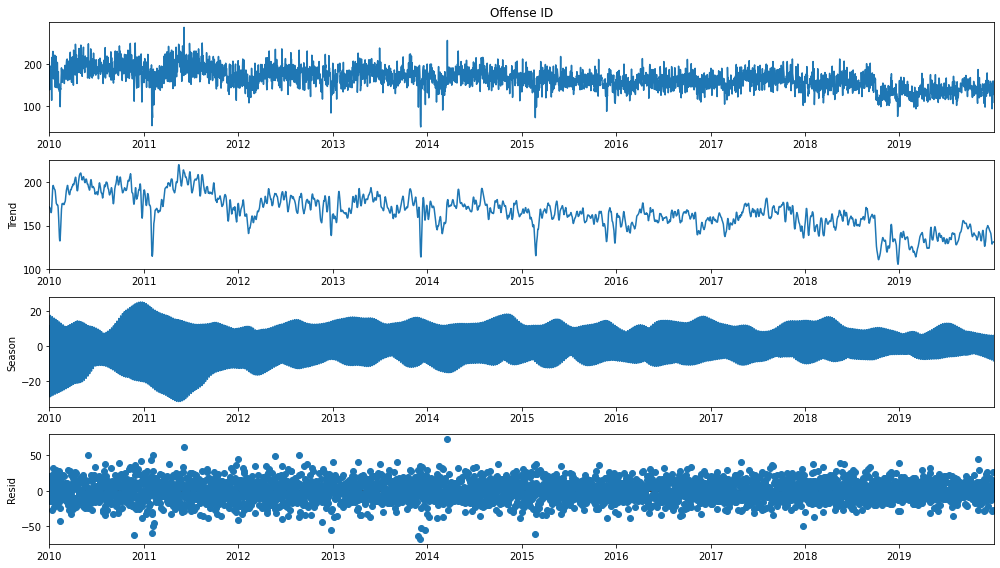

In [46]:
# Weekly seasonality STL LOESS analysis

from statsmodels.tsa.seasonal import STL

stl = STL(daily_totals['Offense ID'], seasonal=31, robust = False)
res = stl.fit()
plt.rc("figure", figsize=(14,8))
fig = res.plot()

**I MIGHT BE ABLE TO REMOVE THE TREND AND SEASON AND MODEL JUST THE RESIDUALS FOR AN EFFECTIVE MODEL!**

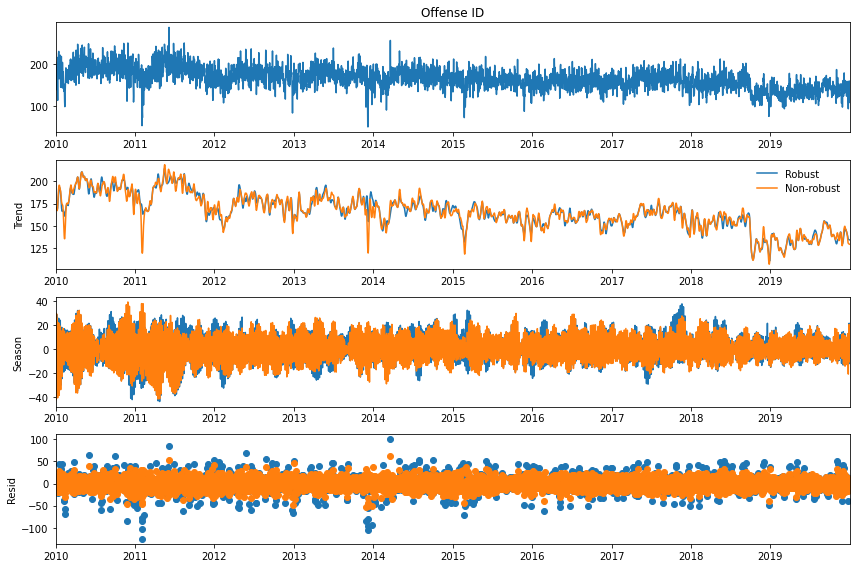

In [22]:
# STL LOESS examination w/ robust side by side

def add_stl_plot(fig, res, legend):
    """Add 3 plots from a second STL fit"""
    axs = fig.get_axes()
    comps = ["trend", "seasonal", "resid"]
    for ax, comp in zip(axs[1:], comps):
        series = getattr(res, comp)
        if comp == "resid":
            ax.plot(series, marker="o", linestyle="none")
        else:
            ax.plot(series)
            if comp == "trend":
                ax.legend(legend, frameon=False)


stl2 = STL(daily_totals['Offense ID'], period=7, robust=True)
res_robust = stl2.fit()
plt.rc("figure", figsize=(12,8))
fig = res_robust.plot()
res_non_robust = STL(daily_totals['Offense ID'], period=7, robust=False).fit()
add_stl_plot(fig, res_non_robust, ["Robust", "Non-robust"])

In [23]:
# STL LOESS examination, robust

stl3 = STL(daily_totals['Offense ID'], period=7, seasonal_deg=0, trend_deg=0, low_pass_deg=0, robust=True)
res_deg_0 = stl.fit()
plt.rc("figure", figsize=(12,8))
fig = res_robust.plot()
add_stl_plot(fig, res_deg_0, ["Degree 1", "Degree 0"])

In [24]:
# ARIMA with forecasting

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.forecasting.stl import STLForecast

daily_totals.index.freq = daily_totals.index.inferred_freq
stlf = STLForecast(daily_totals['Offense ID'], ARIMA, model_kwargs=dict(order=(1, 1, 0), trend="t"))
stlf_res = stlf.fit()

forecast = stlf_res.forecast(7)
plt.plot(daily_totals['Offense ID'])
plt.plot(forecast)
plt.show()

In [25]:
print(stlf_res.summary())

                    STL Decomposition and SARIMAX Results                     
Dep. Variable:                      y   No. Observations:                 3652
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -15378.877
Date:                Tue, 09 Nov 2021   AIC                          30763.754
Time:                        21:34:08   BIC                          30782.362
Sample:                    01-01-2010   HQIC                         30770.381
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0119      0.189     -0.063      0.950      -0.382       0.359
ar.L1         -0.4322      0.014    -31.433      0.000      -0.459      -0.405
sigma2       266.8787      5.665     47.111      0.0

In [26]:
daily_totals['Seasonal Difference'] = daily_totals['Offense ID'].diff(7)

In [27]:
fig = px.line(daily_totals['Offense ID'], x= daily_totals.index, y=daily_totals['Seasonal Difference'])

fig.update_layout(
    yaxis_title="Difference (number)", 
    xaxis_title="Date",
    title="Change in Offense Counts over Prior Year")

fig.show()

In [28]:
# Train/Test Split of Seasonal (7 Days) Difference in Offense Counts

train = daily_totals.loc[daily_totals.index <= '2018-01-01', 'Seasonal Difference'].dropna()
test = daily_totals.loc[daily_totals.index > "2018-01-01", 'Seasonal Difference']

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



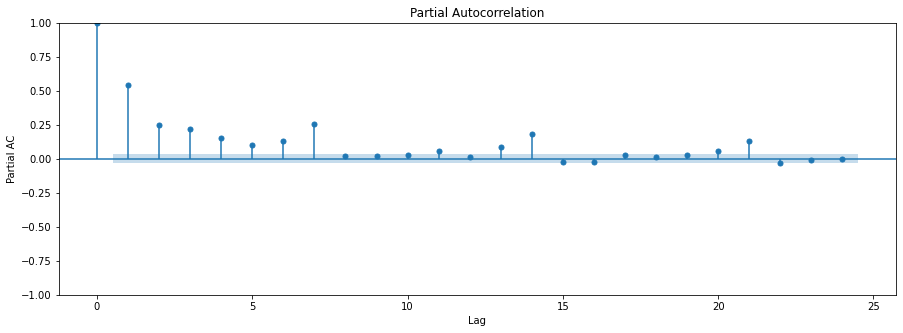

In [29]:
# Partial Autocorrelation Plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(15, 5))
plot_pacf(daily_totals["Offense ID"].dropna(), lags=24, ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('Partial AC')
plt.show()

In [30]:
# Plot of Train/Test Split of Seasonal Difference in Offense counts

fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index, y=train, mode='lines', name="Train"))
fig.add_trace(go.Scatter(x=test.index, y=test, mode='lines', name="Test"))
fig.update_layout(
    yaxis_title="Difference in Offense Counts", 
    xaxis_title="Date",
    title="Train/Test Split of Time Series"
)
fig.show()

Notice how there are multiple seasonalities: Yearly, there is  drastic uptick in crime levels around New Year's Day, with 2016 being the lone exception. Monthly, the highest crime upticks for a given month occur generally on the first 1-2 days of the month. Weekly, there is a generalized rise-and-fall pattern in levels, with rises most prominently on Fridays, Saturdays, and Sundays.

In [31]:
# Time Series Cross-Validation on Offense Counts
from sklearn.model_selection import TimeSeriesSplit

X = train
tscv = TimeSeriesSplit(n_splits=3)

for train_idx, test_idx in tscv.split(X):
    print("Indices (train & test): ", train_idx, test_idx)
    print("Data (train & test): ", X[train_idx], X[test_idx], end="\n\n")

Indices (train & test):  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 2

In [32]:
# Vector Autoregressive Model (multivariate model) fit to counts of Incident, Offense, Victim, and Offender
from statsmodels.tsa.api import VAR

train = daily_totals.loc[daily_totals.index <= '2018-01-01', ['Incident ID', 'Offense ID', 'Victim ID', 'Offender ID']].dropna()
test = daily_totals.loc[daily_totals.index > "2018-01-01", ['Incident ID', 'Offense ID', 'Victim ID', 'Offender ID']]

model = VAR(train) 
results = model.fit(maxlags=2)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 09, Nov, 2021
Time:                     21:34:09
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    17.2997
Nobs:                     2921.00    HQIC:                   17.2526
Log likelihood:          -41701.5    FPE:                3.02806e+07
AIC:                      17.2260    Det(Omega_mle):     2.99103e+07
--------------------------------------------------------------------
Results for equation Incident ID
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                 77.576512         3.358063           23.102           0.000
L1.Incident ID         0.554284         0.113598            4.879           0.000
L1.Offense ID         -0.520671         0.104873  

In [47]:
# SARIMAX Model

from statsmodels.tsa.statespace.sarimax import SARIMAX

p_param = 7

model = SARIMAX(train["Offense ID"], order=(p_param, 0, 0), trend="c")
model_fit = model.fit()

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Offense ID   No. Observations:                 2923
Model:               SARIMAX(7, 0, 0)   Log Likelihood              -12904.577
Date:                Tue, 09 Nov 2021   AIC                          25827.154
Time:                        21:43:54   BIC                          25880.977
Sample:                    01-01-2010   HQIC                         25846.540
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     33.3209      3.580      9.308      0.000      26.305      40.337
ar.L1          0.2521      0.015     16.662      0.000       0.222       0.282
ar.L2          0.0636      0.018      3.521      0.000       0.028       0.099
ar.L3          0.0959      0.018      5.246      0.000       0.060       0.132
ar.L4          0.0487      0.018      2.693      0.007       0.013       0.084
ar.L5          0.0381      0.018      2.077      0.038       0.002       0.074
ar.L6          0.0455      0.019      2.408      0.016       0.008       0.083
ar.L7          0.2615      0.017     15.733      0.000       0.229       0.294
sigma2       399.4414      8.491     47.045      0.000     382.800     416.083
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               183.14
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [34]:
# MAPE ANALYSIS
predictions = pd.Series(data=np.full((train['Offense ID'].shape[0] + test['Offense ID'].shape[0], ), np.mean(train['Offense ID'])), index=pd.concat([train, test]).index)

from sklearn.metrics import mean_absolute_percentage_error

train_mape = mean_absolute_percentage_error(train['Offense ID'], predictions[train.index])
test_mape = mean_absolute_percentage_error(test['Offense ID'], predictions[test.index])

print(f"Train MAPE on the difference: {round(train_mape, 2)}%")
print(f"Test MAPE on the difference: {round(test_mape, 2)}%")

Train MAPE on the difference: 0.12%
Test MAPE on the difference: 0.24%


In [35]:
# Forecast - provide the prior values and the number of steps to predict
pred = results.forecast(train.values, steps=len(test))

df_forecast = pd.DataFrame(pred, index=test.index, columns=test.columns) 
df_forecast

Incident ID  Offense ID   Victim ID  Offender ID
Date                                                        
2018-01-02   152.956161  163.293093  170.177461   188.046370
2018-01-03   159.196710  168.878499  178.380301   197.308751
2018-01-04   158.484321  168.511539  177.556044   196.211539
2018-01-05   159.827065  169.722376  179.090261   198.013004
2018-01-06   160.085376  170.002060  179.337512   198.296222
...                 ...         ...         ...          ...
2019-12-27   161.560927  171.340117  180.920161   200.149884
2019-12-28   161.560927  171.340117  180.920161   200.149884
2019-12-29   161.560927  171.340117  180.920161   200.149884
2019-12-30   161.560927  171.340117  180.920161   200.149884
2019-12-31   161.560927  171.340117  180.920161   200.149884

[729 rows x 4 columns]

In [36]:
pred

array([[152.95616124, 163.29309257, 170.1774608 , 188.0463698 ],
       [159.19671003, 168.87849893, 178.3803011 , 197.30875132],
       [158.48432084, 168.51153891, 177.55604362, 196.21153867],
       ...,
       [161.56092675, 171.34011673, 180.92016068, 200.1498841 ],
       [161.56092675, 171.34011673, 180.92016068, 200.1498841 ],
       [161.56092675, 171.34011673, 180.92016068, 200.1498841 ]])

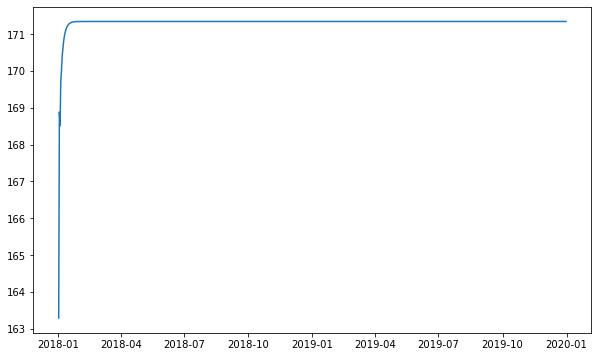

In [37]:
# Simple plot of forecasted values

plt.figure(figsize = (10, 6))
plt.plot(df_forecast.index, 'Offense ID', data=df_forecast)
plt.show()

In [38]:
# Graph object display of forecast vs actual
fig = go.Figure()

# Count of Incidents - orig and forecast
fig.add_trace(go.Scatter(x=daily_totals.index, y=daily_totals['Incident ID'], mode='lines', name="Incident Count", line={'color': 'blue'}))
fig.add_trace(go.Scatter(x=test.index, y=df_forecast['Incident ID'], mode='lines', name="Forecast of Incident Count", line={'dash': 'dash', 'color': 'blue'}))

# Count of Offenses - orig and forecast
fig.add_trace(go.Scatter(x=daily_totals.index, y=daily_totals['Offense ID'], mode='lines', name="Offense Count", line={'color': 'red'}))
fig.add_trace(go.Scatter(x=test.index, y=df_forecast['Offense ID'], mode='lines', name="Forecast of Offense Count", line={'dash': 'dash', 'color': 'red'}))

# Count of Victims - orig and forecast
fig.add_trace(go.Scatter(x=daily_totals.index, y=daily_totals['Victim ID'], mode='lines', name="Victim Count", line={'color': 'yellow'}))
fig.add_trace(go.Scatter(x=test.index, y=df_forecast['Victim ID'], mode='lines', name="Forecast of Victim Counts", line={'dash': 'dash', 'color': 'yellow'}))

# Count of Offenders - orig and forecast
fig.add_trace(go.Scatter(x=daily_totals.index, y=daily_totals['Offender ID'], mode='lines', name="Offender Count", line={'color': 'green'}))
fig.add_trace(go.Scatter(x=test.index, y=df_forecast['Offender ID'], mode='lines', name="Forecast of Offender Counts", line={'dash': 'dash', 'color': 'green'}))


fig.update_layout(
    yaxis_title="Counts", 
    xaxis_title="Year",
    legend_title="Actual Vs Predicted", 
    title="Forecast of Crime Counts 2018-2019 VS Actual"
)
fig.show()

In [39]:
# Prophet predicting setup for Offense Counts
from fbprophet import Prophet

prophet_train = daily_totals.loc[daily_totals.index <= '2018-01-01', ['Offense ID']].dropna().reset_index()
prophet_train.rename(columns={'Date': 'ds', 'Offense ID': 'y'}, inplace=True)
prophet_train.head()

ds    y
0 2010-01-01  204
1 2010-01-02  139
2 2010-01-03  142
3 2010-01-04  187
4 2010-01-05  195

In [54]:
# Fit Prophet model with weekly seasonality
model = Prophet(daily_seasonality=True)
model.fit(prophet_train)

In [55]:
# Make df with future test dates
future = model.make_future_dataframe(periods=len(test), freq="D", include_history=False)
future.head()

ds
0 2018-01-02
1 2018-01-03
2 2018-01-04
3 2018-01-05
4 2018-01-06

In [56]:
# Predict
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
724 2019-12-27  157.545719  135.683334  184.418294
725 2019-12-28  147.741086  122.879338  174.424259
726 2019-12-29  145.037597  120.646951  170.019341
727 2019-12-30  169.492519  144.516210  193.455336
728 2019-12-31  160.000308  134.013362  183.469562

In [57]:
# Plot Prophet results

from fbprophet.plot import plot_plotly

fig = plot_plotly(model, forecast) # returns a plotly Figure object
fig.add_trace(go.Scatter(x=daily_totals.index, 
                         y=daily_totals['Offense ID'], 
                         mode='lines', 
                         name="Offense Count", 
                         line={'color': 'red'}))
fig.update_layout(
    yaxis_title="Counts", 
    xaxis_title="Year",
    legend_title="Actual Vs Predicted", 
    title="Forecast of Criminal Offenses 2010-2019 VS Actual")
fig.show()

In [44]:
%%html
<style>
table {float:left}
</style>

These preliminary models have so far shown that the training data was not accurate in predicting 2018 through 2019.

Overall crime count weekly differences across 51 crime types was steady in variance up until 2017 (400-800 count range.)

2017 had higher overall variation (800-1200 range) and exhibited a distinct upward trend. 
- Only _11.5%_ of all law enforcement agencies in Texas had been reporting their data to NIBRS prior to 2017, according to data from the `agency_participation` table of my database. 
- With the additional 88.5% of agencies reporting, the upward trend to the data reflects the statewide adoption of reporting to NIBRS.

2018's variation was in the 1200-2200 count range, while 2019's range was 2400-3101.

19 offense types stand out as responsible for the drastically different upward trends in 2018 and 2019.  

---

Each of these offense types show an **increase of more than 200%** from 2017's sum totals to 2019's sum totals.


|        **COUNTS > 400%**    | INCREASE |
|------------------------------------------|----------|
| Intimidation                             | 642%     |
| Robbery                                  | 566%     |
| Motor Vehicle Theft                      | 462%     |
| Aggravated Assault                       | 416%     |
| Theft of Motor Vehicle Parts/Accessories | 410%     |


|      **COUNTS > 300%**      | INCREASE |
|------------------------------------------|----------|
| Theft from Motor Vehicle                 | 385%     |
| Simple Assault                           | 350%     |
| Theft from  Building                     | 347%     |
| Weapon Law Violations                    | 338%     |
| Destruction/Damage/Vandalism of Property | 325%     |
| Burglary/Breaking & Entering             | 315%     |
| False Pretenses/Swindle/Confidence Game  | 305%     |
| All Other Larceny                        | 302%     |


|     **COUNTS > 200%**       | INCREASE |
|------------------------------------------|----------|
| Credit Card/ATM Fraud                    | 283%     |
| Fondling                                 | 280%     |
| Counterfeiting/Forgery                   | 278%     |
| Shoplifting                              | 276%     |
| Drug/Narcotic Violations                 | 275%     |
| Rape                                     | 272%     |

Nevertheless, these increases over time must equate to the gradual ramping-up of all agencies reporting to NIBRS.